In [ ]:
!pip install sktime

     |████████████████████████████████| 6.5 MB 5.2 MB/s 
     |████████████████████████████████| 9.8 MB 42.0 MB/s 
     |████████████████████████████████| 3.3 MB 38.7 MB/s 
     |████████████████████████████████| 34.5 MB 13 kB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


In [ ]:
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
# import datsets
from sktime.datasets import load_UCR_UEA_dataset
from sktime.datatypes._panel._convert import from_nested_to_3d_numpy
from pyts.datasets import load_basic_motions

In [ ]:
class reservoir_features:
    '''
    creates an object associated with a multivariate dataset
    
    
    '''
    def __init__(self,data,num_features):
        '''
        data: Takes in a multidimensional array (x * y * z) - z>y
        Initializes it
        x: Timeseries
        y: Attributes for a given timeseries observation
        z: timestamped observations (features)
        
        num_features: you must specify the dimension you want to reduce it to
        
        '''
        self.features = []
        self.filters_used = []
        self.original_data = data.copy()
        self.data = data.copy()
        self.num_features = num_features
        self.x = data.shape[0]
        self.y = data.shape[1]
        self.z = data.shape[2]
        # perform checks 
        #1. 3d numpy array
        #2. Each time series should have same number of observations
        #3. num_features should be less than timestamped observations
    
    def normalize(self):
        '''
        Each attribute could potentially be on a different scale
        modifies the original data and performs a min max normalization
        '''
        for i in range(self.original_data.shape[0]):
            for j in range(self.original_data.shape[1]):
                self.data[i][j] = (self.original_data[i][j] - self.original_data[i][j].min())/(self.original_data[i][j].max()-self.original_data[i][j].min())
    
    
    def filters(self,stride_len = [1], num_filters = 1):
        '''
        stride_len: num of columns to skip after each filter multiplication
        num_filters: you can specify the number of filters you need; each filter will be of a differnt size
        size of filter = n*m 
        (n = # of rows = attribute size, 
        m = # of columns)
        '''
        #Have error check to make sure stride len is a list and value is <length of attributes
        n = self.y
        
        
        #Edge case vals is empty/smaller than num_filters
        
        for iteration in range(num_filters):
            m = self._get_m(stride_len[iteration])
            filter_a = np.random.random((n,m))
            #print("filter of size ", str(n), "*", str(m), "was created\n")
            self.filters_used.append(filter_a)
            
            temp_features =[]
            for i in range(self.x):
                temp = []
                j = 0
                while j + m < self.data.shape[2]:
                    temp.append((filter_a*self.data[i,:,j:j+m]).mean())
                    j+=stride_len[iteration]
                temp_features.append(temp)
            self.features.append(temp_features)
    
    
    def _get_m(self,stride_len):
        '''
        stride_len: 
        based on stride length,& num_features, we calculate possible filter size 
        '''
        m = self.z -(self.num_features)*stride_len
        return m
    
    
    def result_features(self):
        '''
        if multiple filters were added, takes the average result
        '''
        ans =[]
        for timeseries in range(len(self.features[0])):
            temp =[]
            for feature in range(len(self.features[0][0])):
                val = np.mean([self.features[filter][timeseries][feature] for filter in range(len(self.features))])
                temp.append(val)
            ans.append(temp)
        return ans
        

In [ ]:
def transform_data(data, num_features, stride_len, num_filters):
    data_transformed = reservoir_features(data ,num_features = num_features)
    #normalize
    data_transformed.normalize()
    #create 2 filters
    data_transformed.filters(stride_len = stride_len, num_filters = num_filters)
    data_transformed = data_transformed.result_features()
    return data_transformed

## Basic Motions

Mean Time 0.021639223098754882


(array([67., 12.,  5.,  2.,  8.,  4.,  1.,  0.,  0.,  1.]),
 array([0.01788831, 0.02093642, 0.02398453, 0.02703264, 0.03008075,
        0.03312886, 0.03617697, 0.03922508, 0.04227319, 0.0453213 ,
        0.04836941]),
 <a list of 10 Patch objects>)

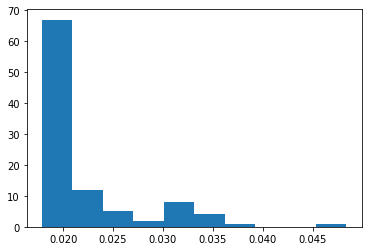

In [ ]:
X_train, X_test, y_train, y_test = load_basic_motions(return_X_y=True)
times = []
for _ in range(100):
  t0 = time.time()
  transform_data(X_train,16,[3],1)
  t1 = time.time()
  times.append(t1-t0)
print("Mean Time",np.mean(times))
plt.hist(times)

## Articulary Word Recognition

0.3922791194915771


(array([76.,  1.,  5.,  8.,  2.,  3.,  1.,  2.,  1.,  1.]),
 array([0.28429651, 0.3686657 , 0.45303488, 0.53740406, 0.62177324,
        0.70614243, 0.79051161, 0.87488079, 0.95924997, 1.04361916,
        1.12798834]),
 <a list of 10 Patch objects>)

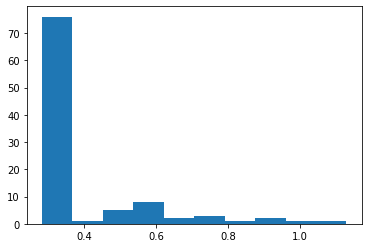

In [ ]:
X_train_WR, y_train_WR = load_UCR_UEA_dataset('ArticularyWordRecognition', split="train", return_X_y=True)
X_train_3d_WR = from_nested_to_3d_numpy(X_train_WR)
times = []
for _ in range(100):
  t0 = time.time()
  transform_data(X_train_3d_WR,40,[3],1)
  t1 = time.time()
  times.append(t1-t0)
print(np.mean(times))
plt.hist(times)

## Atrial Fibrillation

0.027034714221954345


(array([13.,  1., 10., 54., 15.,  2.,  2.,  1.,  1.,  1.]),
 array([0.01537895, 0.01889834, 0.02241774, 0.02593713, 0.02945652,
        0.03297591, 0.0364953 , 0.0400147 , 0.04353409, 0.04705348,
        0.05057287]),
 <a list of 10 Patch objects>)

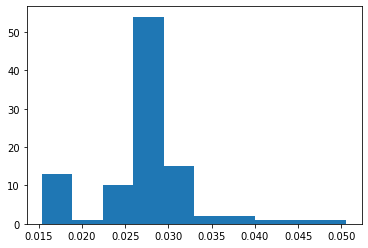

In [ ]:
X_train_AF, y_train_AF = load_UCR_UEA_dataset('AtrialFibrillation', split="train", return_X_y=True)
X_train_3d_AF = from_nested_to_3d_numpy(X_train_AF)
times = []
for _ in range(100):
  t0 = time.time()
  transform_data(X_train_3d_AF,40,[3],1)
  t1 = time.time()
  times.append(t1-t0)
print(np.mean(times))
plt.hist(times)

## Cricket

0.6967822623252868


(array([83.,  3.,  1.,  3.,  1.,  0.,  5.,  3.,  0.,  1.]),
 array([0.61233544, 0.68791211, 0.76348877, 0.83906543, 0.9146421 ,
        0.99021876, 1.06579542, 1.14137208, 1.21694875, 1.29252541,
        1.36810207]),
 <a list of 10 Patch objects>)

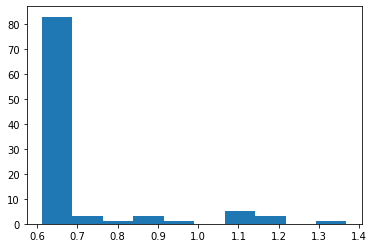

In [ ]:
X_train_C, y_train_C = load_UCR_UEA_dataset('Cricket', split="train", return_X_y=True)
X_train_3d_C = from_nested_to_3d_numpy(X_train_C)
times = []
for _ in range(100):
  t0 = time.time()
  transform_data(X_train_3d_C,200,[3],1)
  t1 = time.time()
  times.append(t1-t0)
print(np.mean(times))
plt.hist(times)

## Epilepsy

0.06314746856689453


(array([41., 31., 16.,  5.,  2.,  3.,  0.,  0.,  1.,  1.]),
 array([0.05702782, 0.06062679, 0.06422577, 0.06782475, 0.07142372,
        0.0750227 , 0.07862167, 0.08222065, 0.08581963, 0.0894186 ,
        0.09301758]),
 <a list of 10 Patch objects>)

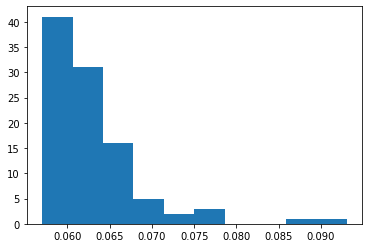

In [ ]:
X_train_E, y_train_E = load_UCR_UEA_dataset('Epilepsy', split="train", return_X_y=True)
X_train_3d_E = from_nested_to_3d_numpy(X_train_E)
times = []
for _ in range(100):
  t0 = time.time()
  transform_data(X_train_3d_E,16,[3],1)
  t1 = time.time()
  times.append(t1-t0)
print(np.mean(times))
plt.hist(times)

## Finger Movements

0.26134534120559694


(array([55., 18.,  5.,  1.,  2.,  2.,  3.,  6.,  2.,  6.]),
 array([0.20852494, 0.23204513, 0.25556531, 0.27908549, 0.30260568,
        0.32612586, 0.34964604, 0.37316623, 0.39668641, 0.42020659,
        0.44372678]),
 <a list of 10 Patch objects>)

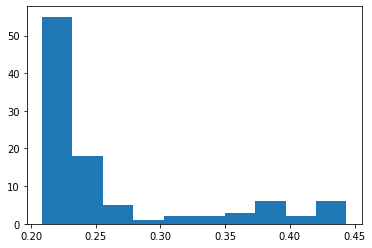

In [ ]:
X_train_FM, y_train_FM = load_UCR_UEA_dataset('FingerMovements', split="train", return_X_y=True)
X_train_3d_FM = from_nested_to_3d_numpy(X_train_FM)
times = []
for _ in range(100):
  t0 = time.time()
  transform_data(X_train_3d_FM,16,[3],1)
  t1 = time.time()
  times.append(t1-t0)
print(np.mean(times))
plt.hist(times)

## Handwriting

0.052572436332702636


(array([60., 14.,  6.,  1.,  0.,  8.,  4.,  5.,  1.,  1.]),
 array([0.04114985, 0.0473047 , 0.05345955, 0.0596144 , 0.06576924,
        0.07192409, 0.07807894, 0.08423378, 0.09038863, 0.09654348,
        0.10269833]),
 <a list of 10 Patch objects>)

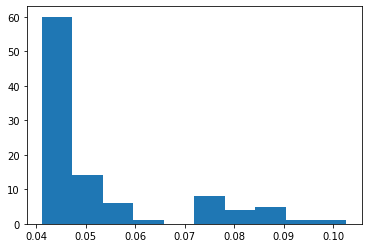

In [ ]:
X_train_H, y_train_H = load_UCR_UEA_dataset('Handwriting', split="train", return_X_y=True)
X_train_3d_H = from_nested_to_3d_numpy(X_train_H)
times = []
for _ in range(100):
  t0 = time.time()
  transform_data(X_train_3d_H,10,[3],1)
  t1 = time.time()
  times.append(t1-t0)
print(np.mean(times))
plt.hist(times)